In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

data1 = pd.read_csv("input/data/data.csv")
data1['Sales'] = data1['Quantity']*data1['UnitPrice']
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [6]:
data1.shape

(541909, 9)

### Hidden missing descriptions

"nan"-Strings?

In [7]:
data1.loc[data1.Description.isnull()==False, "lowercase_descriptions"] = data1.loc[
    data1.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data1.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

False    539724
True        731
Name: lowercase_descriptions, dtype: int64

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

Drop them all:

In [8]:
data1 = data1.loc[(data1.CustomerID.isnull()==False) & (data1.lowercase_descriptions.isnull()==False)].copy()

Cancelled transactions starts with a "C", we droped them all:

In [9]:
data1["IsCancelled"]=np.where(data1.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data1.IsCancelled.value_counts() / data1.shape[0] * 100

False    97.81112
True      2.18888
Name: IsCancelled, dtype: float64

In [10]:
data1 = data1.loc[data1.IsCancelled==False].copy()
data1 = data1.drop("IsCancelled", axis=1)

In [11]:
data1["StockCode"]

0         85123A
1          71053
2         84406B
3         84029G
4         84029E
           ...  
541904     22613
541905     22899
541906     23254
541907     23255
541908     22138
Name: StockCode, Length: 397924, dtype: object

In [12]:
data1.dtypes

InvoiceNo                  object
StockCode                  object
Description                object
Quantity                    int64
InvoiceDate                object
UnitPrice                 float64
CustomerID                float64
Country                    object
Sales                     float64
lowercase_descriptions     object
dtype: object

In [13]:
data1.StockCode.nunique()

3665

In [14]:
data1["CustomerID"] = data1["CustomerID"].astype('int64')

### Most common stockcodes?

Text(0, 0.5, 'Frequency')

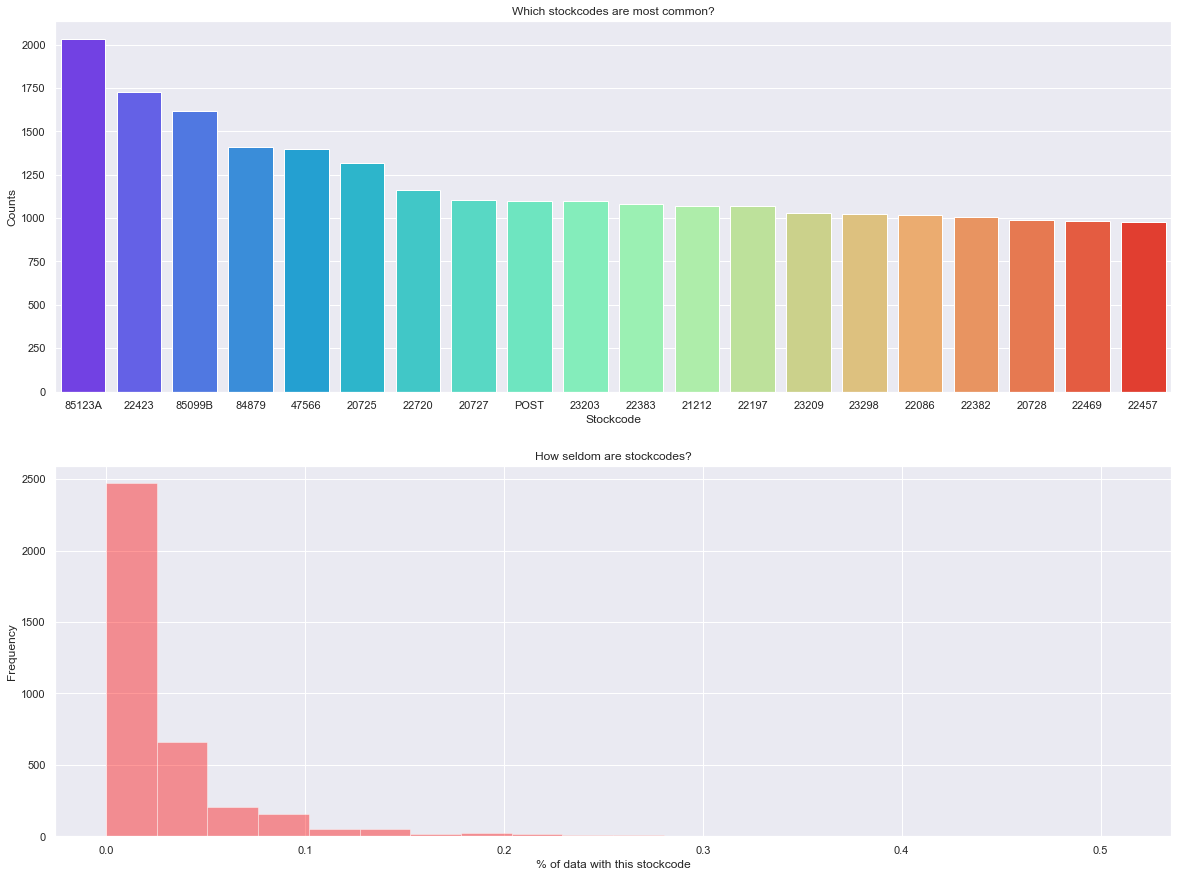

In [15]:
stockcode_counts = data1.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="rainbow")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data1.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="red")

ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency")


Let's count the number of numeric chars in and the length of the stockcode:

In [16]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data1["StockCodeLength"] = data1.StockCode.apply(lambda l: len(l))
data1["nNumericStockCode"] = data1.StockCode.apply(lambda l: count_numeric_chars(l))

In [17]:
data1.loc[data1.nNumericStockCode < 5].lowercase_descriptions.value_counts()

postage                       1099
manual                         290
carriage                       133
dotcom postage                  16
bank charges                    12
pads to match all cushions       4
Name: lowercase_descriptions, dtype: int64

In [18]:
data1 = data1.loc[(data1.nNumericStockCode == 5) & (data1.StockCodeLength==5)].copy()
data1.StockCode.nunique()

2785

In [19]:
data1.StockCode

1         71053
5         22752
6         21730
7         22633
8         22632
          ...  
541904    22613
541905    22899
541906    23254
541907    23255
541908    22138
Name: StockCode, Length: 363119, dtype: object

In [20]:
data1.Description.nunique()

2985

In [21]:
data1.StockCode.nunique()

2785

In [22]:
data1.CustomerID.nunique()

4315

In [23]:
data1 = data1.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

### Description:

Most common descriptions?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'REGENCY CAKESTAND 3 TIER'),
  Text(1, 0, 'ASSORTED COLOUR BIRD ORNAMENT'),
  Text(2, 0, 'PARTY BUNTING'),
  Text(3, 0, 'LUNCH BAG RED RETROSPOT'),
  Text(4, 0, 'SET OF 3 CAKE TINS PANTRY DESIGN '),
  Text(5, 0, 'LUNCH BAG  BLACK SKULL.'),
  Text(6, 0, 'PACK OF 72 RETROSPOT CAKE CASES'),
  Text(7, 0, "PAPER CHAIN KIT 50'S CHRISTMAS "),
  Text(8, 0, 'SPOTTY BUNTING'),
  Text(9, 0, 'LUNCH BAG SPACEBOY DESIGN '),
  Text(10, 0, 'LUNCH BAG CARS BLUE'),
  Text(11, 0, 'HEART OF WICKER SMALL'),
  Text(12, 0, 'NATURAL SLATE HEART CHALKBOARD '),
  Text(13, 0, 'LUNCH BAG PINK POLKADOT'),
  Text(14, 0, 'REX CASH+CARRY JUMBO SHOPPER'),
  Text(15, 0, 'LUNCH BAG SUKI DESIGN '),
  Text(16, 0, 'ALARM CLOCK BAKELIKE RED '),
  Text(17, 0, 'LUNCH BAG APPLE DESIGN'),
  Text(18, 0, 'SET OF 4 PANTRY JELLY MOULDS'),
  Text(19, 0, 'JUMBO BAG PINK POLKADOT'),
  T

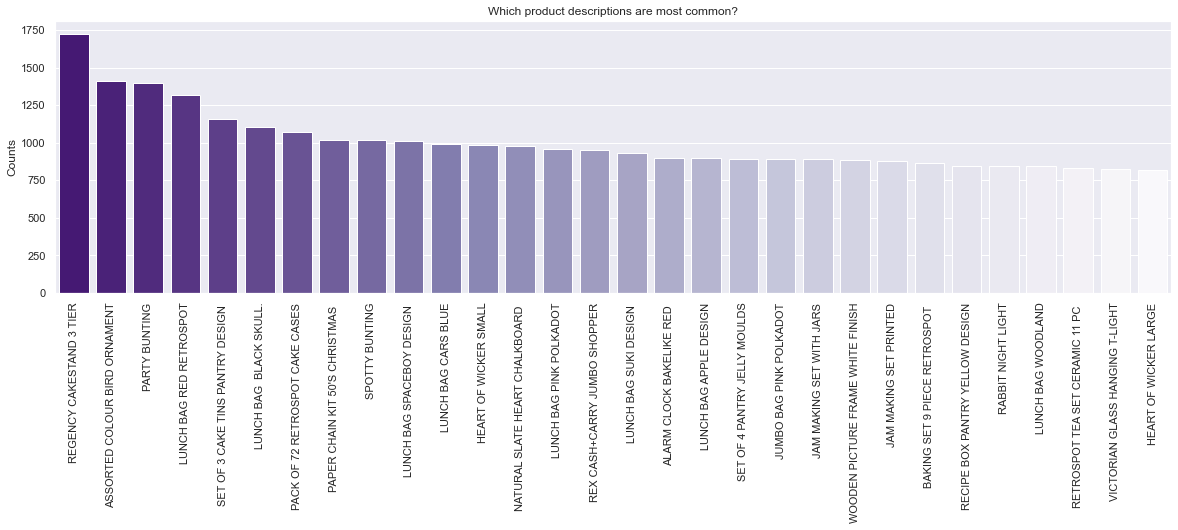

In [24]:
description_counts = data1.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90)

In [25]:
data1.loc[data1.CustomerID == '17841'].Description

Series([], Name: Description, dtype: object)

Some descriptions correspond to a similar product type.
We often have color information about the product as well. 

In [26]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [27]:
data1["DescriptionLength"] = data1.Description.apply(lambda l: len(l))
data1["LowCharsInDescription"] = data1.Description.apply(lambda l: count_lower_chars(l))

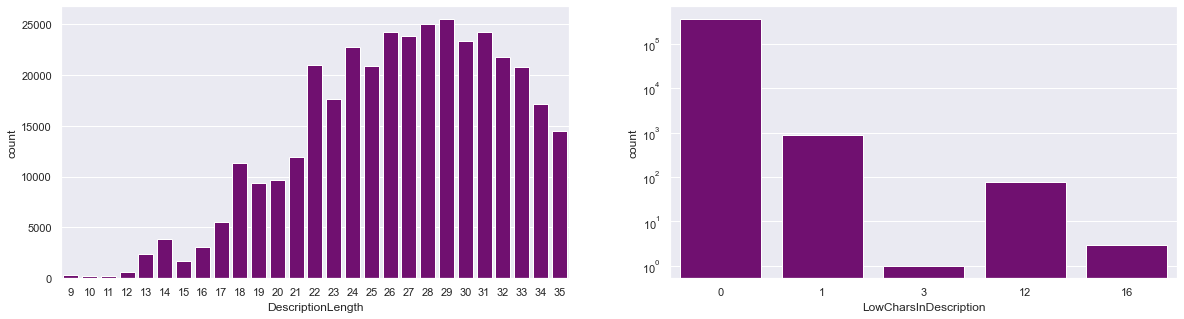

In [28]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data1.DescriptionLength, ax=ax[0], color="Purple")
sns.countplot(data1.LowCharsInDescription, ax=ax[1], color="Purple")
ax[1].set_yscale("log")

In [29]:
data1.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23196    4
23236    4
23535    3
23126    3
23203    3
23209    3
23413    3
23396    3
23231    3
23240    3
Name: Description, dtype: int64

We have stockcodes with multiple descriptions. Browsing through the cases we can see that stockcodes are sometimes named a bit differently due to missing or changed words or typing errors.

In [30]:
data1.groupby(["StockCode","CustomerID"]).Quantity.sum()

StockCode  CustomerID
10002      12451         12
           12510         24
           12583         48
           12637         12
           12673          1
                         ..
90204      17976          1
90208      12748          1
           14911          6
           17360          2
           17596          1
Name: Quantity, Length: 243710, dtype: int64

### Customers:

In [31]:
data1.CustomerID.nunique()

4315

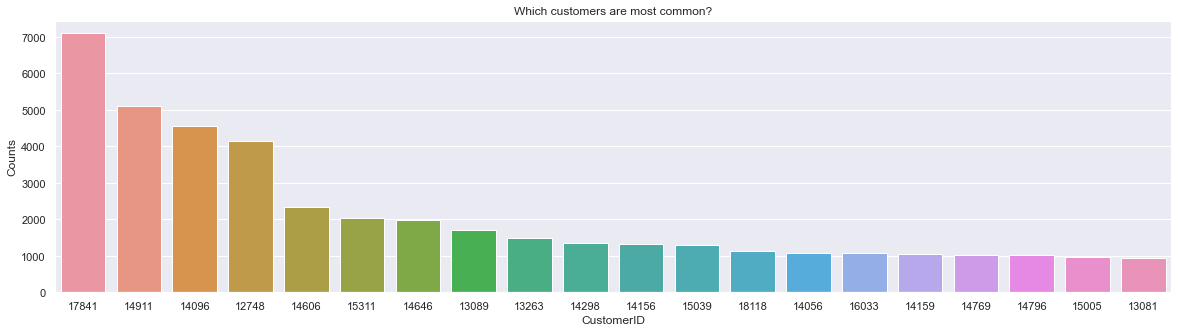

In [32]:
customer_counts = data1.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

### UnitPrice & Quantity

In [33]:
data1.UnitPrice.describe()

count    363119.000000
mean          2.886098
std           4.361971
min           0.000000
25%           1.250000
50%           1.700000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [34]:
data1.shape

(363119, 12)

Let's focus transactions with prices that fall into this range as we don't want to make predictions for very seldom products with high prices.

In [35]:
data1 = data1.loc[(data1.UnitPrice > 0.1) & (data1.UnitPrice < 20)].copy()

In [36]:
data1 = data1.loc[data1.Quantity < 55].copy()

In [37]:
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,lowercase_descriptions,DescriptionLength,LowCharsInDescription
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34,white metal lantern,19,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom,15.30,set 7 babushka nesting boxes,28,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom,25.50,glass star frosted t-light holder,33,0
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10,hand warmer union jack,22,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10,hand warmer red polka dot,25,0


In [38]:
data1.shape

(352019, 12)

### Preprocessing

In [39]:
data1 = data1.drop(["DescriptionLength","LowCharsInDescription","lowercase_descriptions"],axis =1)

In [40]:
#Data cleaning using Texthero:
from texthero import preprocessing
import texthero as hero

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_brackets
                  ]
data1['Description'] = hero.clean(data1['Description'], custom_pipeline)
#df['Description'] = [n.replace('{','') for n in df['Description']]

data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
5,536365,22752,set 7 babushka nesting boxes,2,12/1/2010 8:26,7.65,17850,United Kingdom,15.30
6,536365,21730,glass star frosted t-light holder,6,12/1/2010 8:26,4.25,17850,United Kingdom,25.50
7,536366,22633,hand warmer union jack,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10
8,536366,22632,hand warmer red polka dot,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10


### Daily sales


Extract temporal features out of the InvoiceDate.

In [41]:
data1["InvoiceDate"] = pd.to_datetime(data1.InvoiceDate, cache=True)

data1["Year"] = data1.InvoiceDate.dt.year
data1["Quarter"] = data1.InvoiceDate.dt.quarter
data1["Month"] = data1.InvoiceDate.dt.month
data1["Week"] = data1.InvoiceDate.dt.week
data1["Weekday"] = data1.InvoiceDate.dt.weekday
data1["Day"] = data1.InvoiceDate.dt.day
data1["Dayofyear"] = data1.InvoiceDate.dt.dayofyear
data1["Date"] = pd.to_datetime(data1[['Year', 'Month', 'Day']])


In [42]:
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01
7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01
8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01


In [43]:
data1.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
Sales                 float64
Year                    int64
Quarter                 int64
Month                   int64
Week                    int64
Weekday                 int64
Day                     int64
Dayofyear               int64
Date           datetime64[ns]
dtype: object

In [44]:
pd.unique(data1.Weekday)
#0 = Mon
#1 = Tue
#2 = Wed
#3 = Thu
#4 = Fri
#6 = Sun
#There is no Saturday

array([2, 3, 4, 6, 0, 1], dtype=int64)

In [45]:
data1["is_weekend"] = data1["Weekday"].isin([5, 6]).astype(np.int8)

In [46]:
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01,0
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01,0
7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0
8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0


In [47]:
(data1.loc[data1.Weekday==6]).nunique()

InvoiceNo      2119
StockCode      2566
Description    2636
Quantity         47
InvoiceDate    1980
UnitPrice       108
CustomerID     1203
Country          19
Sales           855
Year              2
Quarter           4
Month            12
Week             49
Weekday           1
Day              31
Dayofyear        50
Date             50
is_weekend        1
dtype: int64

In [48]:
(data1.loc[data1.Weekday==6]).shape

(56376, 18)

In [49]:
data1.loc[data1.Weekday==6].Quantity.sum()
#11.40 % on Sun

335005

In [50]:
data1.loc[data1.Weekday==6].Quantity.sum()

335005

### New Products:

In [51]:
NPI = pd.DataFrame(data1.groupby(['StockCode']).agg({'Date': 'first','Year': 'first', 'Month': 'first','Week': 'first',"Day": 'first', 'Weekday': 'first',
                                                                'is_weekend' : 'first',    'Quantity': 'sum', 'UnitPrice': 'mean','Sales':'sum','Description':"first"}))
NPI = NPI.reset_index()
NPI

,StockCode,Date,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
0,10002,2010-12-01,2010,12,48,1,2,0,461,0.850000,391.85,inflatable political globe
1,10080,2011-02-27,2011,2,8,27,6,1,291,0.411905,114.41,groovy cactus inflatable
2,10120,2010-12-03,2010,12,48,3,4,0,193,0.210000,40.53,doggy rubber
3,10125,2010-12-01,2010,12,48,1,2,0,756,0.784407,556.60,mini funky design tapes
4,10133,2010-12-01,2010,12,48,1,2,0,1814,0.529322,874.11,colouring pencils brown tube
...,...,...,...,...,...,...,...,...,...,...,...,...
2747,90191,2011-02-20,2011,2,7,20,6,1,22,8.550000,113.90,silver lariat 40cm
2748,90192,2011-02-14,2011,2,7,14,0,0,23,4.950000,113.85,jade drop earrings w filigree
2749,90194,2010-12-16,2010,12,50,16,3,0,12,4.250000,51.00,silver lariat black stone earrings
2750,90204,2010-12-02,2010,12,48,2,3,0,17,3.350000,56.95,pair of enamel butterfly hairclip


In [52]:
new_products = NPI.StockCode[(NPI.Date >= '2011-09-01')]
new_products = set(new_products)
print(len(new_products))
print(new_products)

233
{'23497', '23377', '23516', '23414', '23484', '23515', '23380', '23567', '23575', '23401', '23406', '23367', '23368', '23519', '23583', '23462', '23381', '23393', '23394', '23468', '84550', '23660', '23408', '23398', '23521', '23459', '72783', '23579', '23415', '23365', '23416', '23058', '23503', '90074', '23452', '23512', '23498', '21277', '90188', '23531', '23428', '90169', '23376', '23116', '23576', '23529', '35964', '23551', '23463', '23411', '23559', '23400', '23303', '23422', '23453', '23695', '23509', '23457', '23527', '23517', '23568', '23470', '23442', '23423', '23506', '23580', '23597', '23466', '84016', '23441', '23487', '23539', '23402', '23460', '23382', '23565', '23425', '90071', '23395', '23074', '23554', '23479', '23446', '23500', '23114', '23489', '23501', '23520', '23523', '23553', '23556', '23540', '47016', '23429', '20678', '23558', '23474', '23562', '23417', '23447', '23410', '23505', '23113', '90119', '23681', '23491', '23461', '23475', '23492', '23407', '2347

In [53]:
#new_products are after date '2011-09-01':
data1[(data1.StockCode.isin(new_products)) & (data1.Date <'2011-09-01')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend


In [54]:
new_data = NPI[NPI.StockCode.isin(new_products)]
print(new_data.shape)
new_data.head()

(233, 12)


,StockCode,Date,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
66,20678,2011-09-23,2011,9,38,23,4,0,4,1.650000,6.60,large black diamante hairslide
191,20935,2011-09-23,2011,9,38,23,4,0,6,2.950000,17.70,round cactus candle
389,21277,2011-09-29,2011,9,39,29,3,0,4,15.475000,68.85,french style embossed heart cabinet
941,22125,2011-11-23,2011,11,47,23,2,0,4,5.950000,23.80,union jack hot water bottle
1800,23058,2011-09-14,2011,9,37,14,2,0,486,1.112955,421.02,christmas hanging snowflake


In [55]:
val_products = NPI.StockCode[(~(NPI.StockCode.isin(new_products))) & (NPI.Date >= '2011-08-01')]
val_products = set(val_products)
print(len(val_products))
print(val_products)

38
{'23375', '23349', '23431', '23331', '23438', '23360', '23352', '23432', '23327', '23356', '23358', '23189', '23359', '35650', '23334', '23328', '23329', '23330', '23324', '23374', '23332', '23326', '23354', '23445', '23333', '22340', '23350', '23348', '23353', '23436', '23373', '23437', '23357', '23355', '23439', '23433', '23325', '23351'}


In [56]:
data1[data1.StockCode.isin(val_products) & (data1.Date < '2011-08-01')]
#data1[data1.StockCode.isin(new_products)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend


#### Daily Data:

In [57]:
daily_data = pd.DataFrame(data1.groupby(['Date','StockCode']).agg({'Year': 'first', 'Month': 'first','Week': 'first',"Day": 'first', 'Weekday': 'first',
                                                                'is_weekend' : 'first',    'Quantity': 'sum', 'UnitPrice': 'mean','Sales':'sum','Description':"first"}))

In [58]:
daily_data = daily_data.reset_index()
daily_data.head()

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
0,2010-12-01,10002,2010,12,48,1,2,0,60,0.85,51.00,inflatable political globe
1,2010-12-01,10125,2010,12,48,1,2,0,2,0.85,1.70,mini funky design tapes
2,2010-12-01,10133,2010,12,48,1,2,0,5,0.85,4.25,colouring pencils brown tube
3,2010-12-01,16014,2010,12,48,1,2,0,10,0.42,4.20,small chinese style scissor
4,2010-12-01,16016,2010,12,48,1,2,0,10,0.85,8.50,large chinese style scissor


In [59]:
daily_data.loc[:, ["Quantity", "Sales"]].describe()

,Quantity,Sales
count,196191.000000,196191.000000
mean,14.968852,28.187982
std,18.811419,43.918628
min,1.000000,0.120000
25%,3.000000,6.950000
50%,9.000000,15.300000
75%,20.000000,30.710000
max,411.000000,1266.300000


In [60]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 89.0)


In [61]:
low_Sales = daily_data.Sales.quantile(0.01)
high_Sales = daily_data.Sales.quantile(0.99)
print((low_Sales, high_Sales))

(0.78, 204.0)


In [62]:
samples = daily_data.shape[0]

In [63]:
#Remove these just from the plot not from the data

daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Sales >= low_Sales) & (daily_data.Sales <= high_Sales)]

In [64]:
#How much entries have we lost?
samples - daily_data.shape[0]

5243

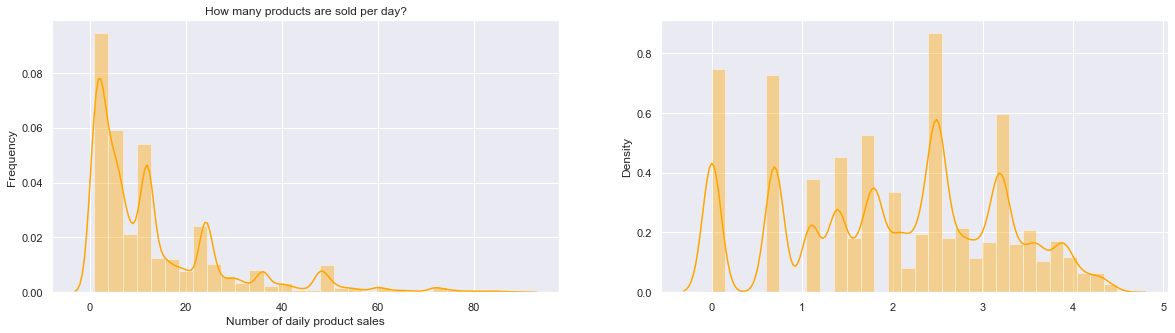

In [65]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

#### New product split:

In [66]:
print(pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(new_products)].groupby("StockCode")).shape)
New_data1 = pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(new_products)])

New_data1

(232, 2)


,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
120864,2011-09-01,23376,2011,9,35,1,3,0,48,0.390,18.72,pack of 12 vintage christmas tissue
120865,2011-09-01,23378,2011,9,35,1,3,0,48,0.390,18.72,pack of 12 50's christmas tissues
120878,2011-09-01,23551,2011,9,35,1,3,0,12,0.390,4.68,pack of 12 paisley park tissues
122173,2011-09-04,23377,2011,9,35,4,6,1,12,0.390,4.68,pack of 12 dolly girl tissues
122174,2011-09-04,23393,2011,9,35,4,6,1,10,3.750,37.50,home sweet home cushion cover
...,...,...,...,...,...,...,...,...,...,...,...,...
196160,2011-12-09,23570,2011,12,49,9,4,0,24,1.250,30.00,traditional pick up sticks game
196161,2011-12-09,23571,2011,12,49,9,4,0,12,1.650,19.80,traditional naughts & crosses
196162,2011-12-09,23581,2011,12,49,9,4,0,50,1.935,92.40,jumbo bag paisley park
196163,2011-12-09,23598,2011,12,49,9,4,0,6,2.950,17.70,paper bunting vintage party


In [67]:
# it doesn't contain val_products
old_products = NPI.StockCode[(~NPI.StockCode.isin(new_products)) & (~NPI.StockCode.isin(val_products))]
old_products = set(old_products)
print(len(old_products)) 

2481


In [68]:
old_data = data1[data1.StockCode.isin(old_products) ]#& (data1.Date < '2011-08-01')
print(old_data.shape)
old_data

(330913, 18)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01,0
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01,0
7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0
8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011,4,12,49,4,9,343,2011-12-09,0
541905,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011,4,12,49,4,9,343,2011-12-09,0
541906,581587,23254,childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,4,12,49,4,9,343,2011-12-09,0
541907,581587,23255,childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,4,12,49,4,9,343,2011-12-09,0


In [69]:
print(pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(old_products)].groupby("StockCode")).shape)
Old_data1 = pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(old_products)]) # & (daily_data.Date < '2011-08-01') 

Old_data1

(2479, 2)


,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
0,2010-12-01,10002,2010,12,48,1,2,0,60,0.85,51.00,inflatable political globe
1,2010-12-01,10125,2010,12,48,1,2,0,2,0.85,1.70,mini funky design tapes
2,2010-12-01,10133,2010,12,48,1,2,0,5,0.85,4.25,colouring pencils brown tube
3,2010-12-01,16014,2010,12,48,1,2,0,10,0.42,4.20,small chinese style scissor
4,2010-12-01,16016,2010,12,48,1,2,0,10,0.85,8.50,large chinese style scissor
...,...,...,...,...,...,...,...,...,...,...,...,...
196186,2011-12-09,85038,2011,12,49,9,4,0,84,1.85,155.40,6 chocolate love heart t-lights
196187,2011-12-09,85053,2011,12,49,9,4,0,2,2.10,4.20,french enamel candleholder
196188,2011-12-09,85066,2011,12,49,9,4,0,4,12.75,51.00,cream sweetheart mini chest
196189,2011-12-09,85152,2011,12,49,9,4,0,48,1.85,88.80,hand over the chocolate sign


In [70]:
val_data = data1[data1.StockCode.isin(val_products)]# & (data1.Date < '2011-09-01')
print(val_data.shape)
val_data

(6187, 18)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend
285702,561917,35650,vintage bead pink jewel stand,1,2011-08-01 11:57:00,4.95,16904,United Kingdom,4.95,2011,3,8,31,0,1,213,2011-08-01,0
287087,562049,23360,set 8 candles vintage doiley,12,2011-08-02 11:33:00,1.95,14133,United Kingdom,23.40,2011,3,8,31,1,2,214,2011-08-02,0
287135,562085,23359,set of 12 t-lights vintage doiley,12,2011-08-02 12:27:00,1.95,15228,United Kingdom,23.40,2011,3,8,31,1,2,214,2011-08-02,0
287136,562085,23360,set 8 candles vintage doiley,12,2011-08-02 12:27:00,1.95,15228,United Kingdom,23.40,2011,3,8,31,1,2,214,2011-08-02,0
287286,562101,23373,vintage christmas paper gift bag,10,2011-08-02 14:04:00,0.82,13850,United Kingdom,8.20,2011,3,8,31,1,2,214,2011-08-02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541813,581579,23353,6 gift tags vintage christmas,12,2011-12-09 12:19:00,0.83,17581,United Kingdom,9.96,2011,4,12,49,4,9,343,2011-12-09,0
541814,581579,23350,roll wrap vintage spot,25,2011-12-09 12:19:00,1.25,17581,United Kingdom,31.25,2011,4,12,49,4,9,343,2011-12-09,0
541836,581580,23334,ivory wicker heart small,4,2011-12-09 12:20:00,0.63,12748,United Kingdom,2.52,2011,4,12,49,4,9,343,2011-12-09,0
541878,581585,23356,love hot water bottle,3,2011-12-09 12:31:00,5.95,15804,United Kingdom,17.85,2011,4,12,49,4,9,343,2011-12-09,0


In [71]:
print(pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(val_products)].groupby("StockCode")).shape)
Val_data1 = pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(val_products)])# & (daily_data.Date < '2011-09-01') 

Val_data1

(38, 2)


,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
105967,2011-08-01,35650,2011,8,31,1,0,0,1,4.95,4.95,vintage bead pink jewel stand
106561,2011-08-02,23353,2011,8,31,2,1,0,12,0.83,9.96,6 gift tags vintage christmas
106562,2011-08-02,23354,2011,8,31,2,1,0,12,0.83,9.96,6 gift tags 50's christmas
106563,2011-08-02,23359,2011,8,31,2,1,0,12,1.95,23.40,set of 12 t-lights vintage doiley
106564,2011-08-02,23360,2011,8,31,2,1,0,24,1.95,46.80,set 8 candles vintage doiley
...,...,...,...,...,...,...,...,...,...,...,...,...
196124,2011-12-09,23358,2011,12,49,9,4,0,18,1.25,22.50,hot stuff hot water bottle
196137,2011-12-09,23437,2011,12,49,9,4,0,12,1.25,15.00,50's christmas gift bag large
196138,2011-12-09,23438,2011,12,49,9,4,0,12,1.25,15.00,red spot gift bag large
196139,2011-12-09,23439,2011,12,49,9,4,0,36,2.10,75.60,hand warmer red love heart


In [72]:
len(old_products)+len(val_products)+len(new_products)==len(set(data1.StockCode))

True

In [73]:
(Old_data1.shape[0]) + (New_data1.shape[0]) + (Val_data1.shape[0]) == daily_data.shape[0]

True

In [74]:
# meeting:

#NER on Description
#label descriptions
#NPI: new product  
#short history of products
#cosine similarity of description embeddings 
#trainig set= last 3month
#metric to find the best embeddings for forecast
#KNN
#use metric just on NPI


In [75]:
#separate old, validation and new products:
old_desc = set(list(Old_data1['Description']))
old_desc = list(old_desc)
print(len(old_desc))

2596


In [76]:
val_desc = set(list(Val_data1['Description']))
val_desc = list(val_desc)
print(len(val_desc))

45


In [77]:
new_desc = set(list(New_data1['Description']))
new_desc = list(new_desc)
print(len(new_desc))

273


### Vectorize Description:

In [78]:
#ROBERTA:
from sentence_transformers import SentenceTransformer, util
roberta_model = SentenceTransformer('stsb-roberta-base-v2')
roberta_model.max_seq_length = 200


In [79]:
roberta_old = roberta_model.encode(old_desc)

In [80]:
roberta_old.shape

(2596, 768)

#### UMAP:

In [81]:
import umap
import umap.plot
UMAP_roberta = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(roberta_old)

In [82]:
UMAP_roberta

array([[ 1.2623702,  7.320811 ],
       [-1.7710717,  7.6635675],
       [-1.9459708,  3.7052174],
       ...,
       [ 0.9181605,  5.173029 ],
       [-1.7822169,  4.3801126],
       [ 1.0339164,  5.9184566]], dtype=float32)

##### HDBSCAN:

In [83]:
#https://github.com/scikit-learn-contrib/hdbscan
import hdbscan

In [84]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=18,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(UMAP_roberta)

In [85]:
len(set(clusterer.labels_))

39

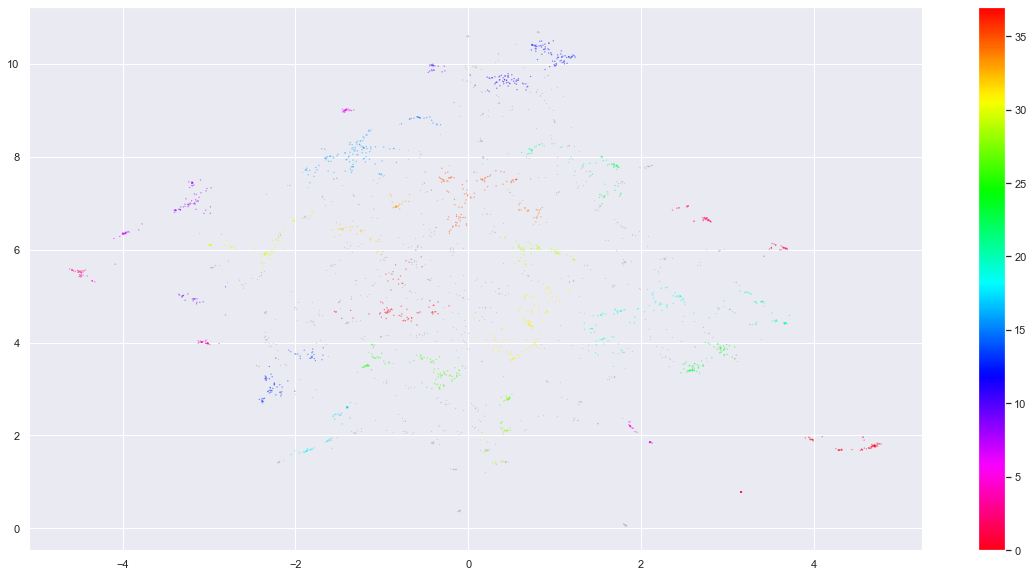

In [86]:
import matplotlib.pyplot as plt

# Prepare data
result = pd.DataFrame(UMAP_roberta, columns=['x', 'y'])
result['labels'] = clusterer.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [87]:
desc_df = pd.DataFrame(old_desc, columns=["Desc"])
desc_df['Topic'] = clusterer.labels_
desc_per_topic = desc_df.groupby(['Topic'], as_index = False).agg({'Desc': ' '.join})

In [96]:
desc_df

,Desc,Topic
0,green with metal bag charm,-1
1,3d vintage christmas stickers,16
2,black record cover frame,14
3,fridge magnets us diner assorted,9
4,pens assorted funky jeweled,-1
...,...,...
2591,red gingham teddy bear,-1
2592,pink flock glass candleholder,12
2593,mini ladle love heart pink,31
2594,easter tin keepsake,-1


In [97]:
data_df = pd.DataFrame(Old_data1, columns=['Date','StockCode','Year','Month','Week','Day','Weekday','is_weekend','Quantity','Description'])

In [98]:
data_df

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes
2,2010-12-01,10133,2010,12,48,1,2,0,5,colouring pencils brown tube
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor
...,...,...,...,...,...,...,...,...,...,...
196186,2011-12-09,85038,2011,12,49,9,4,0,84,6 chocolate love heart t-lights
196187,2011-12-09,85053,2011,12,49,9,4,0,2,french enamel candleholder
196188,2011-12-09,85066,2011,12,49,9,4,0,4,cream sweetheart mini chest
196189,2011-12-09,85152,2011,12,49,9,4,0,48,hand over the chocolate sign


In [99]:
topics = {}
for i in list(set(clusterer.labels_)):
    if (i !=-1):
        topics["D{0}".format(i)] = list(desc_df["Desc"][desc_df['Topic']== i])

In [100]:
topics.keys()

dict_keys(['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32', 'D33', 'D34', 'D35', 'D36', 'D37'])

In [101]:
#data_df['Topic'] = 'Null'
data_df

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe,Null
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes,Null
2,2010-12-01,10133,2010,12,48,1,2,0,5,colouring pencils brown tube,Null
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor,Null
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor,Null
...,...,...,...,...,...,...,...,...,...,...,...
196186,2011-12-09,85038,2011,12,49,9,4,0,84,6 chocolate love heart t-lights,Null
196187,2011-12-09,85053,2011,12,49,9,4,0,2,french enamel candleholder,Null
196188,2011-12-09,85066,2011,12,49,9,4,0,4,cream sweetheart mini chest,Null
196189,2011-12-09,85152,2011,12,49,9,4,0,48,hand over the chocolate sign,Null


In [103]:
#to add topic -1:
D_1 = list(desc_df["Desc"][desc_df['Topic']== -1])

In [104]:
for index, row in data_df.iterrows():
    if (row['Description'] in D_1):
        data_df['Topic'][index] = -1

In [105]:
for index, row in data_df.iterrows():
    for i in range(len(topics.keys())):
        if (row['Description'] in list(topics.values())[i]):
            data_df['Topic'][index] = i

In [106]:
data_df

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe,-1
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes,-1
2,2010-12-01,10133,2010,12,48,1,2,0,5,colouring pencils brown tube,18
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor,-1
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor,-1
...,...,...,...,...,...,...,...,...,...,...,...
196186,2011-12-09,85038,2011,12,49,9,4,0,84,6 chocolate love heart t-lights,8
196187,2011-12-09,85053,2011,12,49,9,4,0,2,french enamel candleholder,12
196188,2011-12-09,85066,2011,12,49,9,4,0,4,cream sweetheart mini chest,32
196189,2011-12-09,85152,2011,12,49,9,4,0,48,hand over the chocolate sign,0


In [107]:
# change stockcode and Topic type to category:
data_df["StockCode"] = data_df["StockCode"].astype('category')
data_df["Topic"] = data_df["Topic"].astype('category')

In [108]:
data_df.dtypes

Date           datetime64[ns]
StockCode            category
Year                    int64
Month                   int64
Week                    int64
Day                     int64
Weekday                 int64
is_weekend               int8
Quantity                int64
Description            object
Topic                category
dtype: object

##### Here we just split the whole data to train, validation, test. And didn't keep the Topic as a new feature:

In [110]:
x_tr_no_topic_df = data_df[(data_df['Date'] <= '2011-08-01')].drop(['Date','Description','Quantity','Topic'],axis = 1)
x_tr_no_topic_df

,StockCode,Year,Month,Week,Day,Weekday,is_weekend
0,10002,2010,12,48,1,2,0
1,10125,2010,12,48,1,2,0
2,10133,2010,12,48,1,2,0
3,16014,2010,12,48,1,2,0
4,16016,2010,12,48,1,2,0
...,...,...,...,...,...,...,...
106018,85078,2011,8,31,1,0,0
106019,85152,2011,8,31,1,0,0
106020,85161,2011,8,31,1,0,0
106021,85172,2011,8,31,1,0,0


In [111]:
y_tr_no_topic_df = data_df[(data_df['Date'] <= '2011-08-01')]['Quantity']
y_tr_no_topic_df.shape

(103685,)

In [112]:
x_val_no_topic_df = data_df[(data_df['Date']>'2011-08-01') & (data_df['Date']<='2011-10-01')].drop(['Date','Description','Quantity','Topic'],axis = 1)
x_val_no_topic_df

,StockCode,Year,Month,Week,Day,Weekday,is_weekend
106023,10080,2011,8,31,2,1,0
106024,10120,2011,8,31,2,1,0
106025,15036,2011,8,31,2,1,0
106026,15039,2011,8,31,2,1,0
106027,16235,2011,8,31,2,1,0
...,...,...,...,...,...,...,...
139927,85152,2011,9,39,30,4,0
139928,85173,2011,9,39,30,4,0
139929,85212,2011,9,39,30,4,0
139930,85227,2011,9,39,30,4,0


In [113]:
y_val_no_topic_df = data_df[(data_df['Date']>'2011-08-01') & (data_df['Date']<='2011-10-01')]['Quantity']
y_val_no_topic_df.shape

(31271,)

In [114]:
x_te_no_topic_df = data_df[(data_df['Date']>'2011-10-01')].drop(['Date','Description','Quantity','Topic'],axis = 1)
x_te_no_topic_df

,StockCode,Year,Month,Week,Day,Weekday,is_weekend
139934,10125,2011,10,39,2,6,1
139935,16236,2011,10,39,2,6,1
139936,17003,2011,10,39,2,6,1
139938,20668,2011,10,39,2,6,1
139939,20679,2011,10,39,2,6,1
...,...,...,...,...,...,...,...
196186,85038,2011,12,49,9,4,0
196187,85053,2011,12,49,9,4,0
196188,85066,2011,12,49,9,4,0
196189,85152,2011,12,49,9,4,0


In [115]:
y_te_no_topic_df = data_df[(data_df['Date']>'2011-10-01')]['Quantity']
y_te_no_topic_df.shape

(46935,)

In [116]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

#optimization:
def objective(trial):



        param = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': 20000,
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 10, 1000),# 32,64,.... descrite 
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
        }


        model_no_topic_df = LGBMRegressor(**param)
        model_no_topic_df.fit(x_tr_no_topic_df,y_tr_no_topic_df,
                                        eval_set=[(x_val_no_topic_df,y_val_no_topic_df)],early_stopping_rounds=100,verbose=False)
        pred_no_topic_df = model_no_topic_df.predict(x_te_no_topic_df)
        rmse_no_topic_df = mean_squared_error(y_te_no_topic_df, 
                                                       model_no_topic_df.predict(x_te_no_topic_df), squared=False)

        return rmse_no_topic_df    
    
    
    
    

In [117]:
# the objective of our fuction is to minimize the RMSE that's why direction='minimize':
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
params=study.best_params   


model_no_topic_df= LGBMRegressor(**params)
model_no_topic_df.fit(x_tr_no_topic_df,y_tr_no_topic_df,
                                        eval_set=[(x_val_no_topic_df,y_val_no_topic_df)],early_stopping_rounds=100,verbose=False)
pred_no_topic_df = model_no_topic_df.predict(x_te_no_topic_df)
rmse_no_topic_df = mean_squared_error(y_te_no_topic_df, model_no_topic_df.predict(x_te_no_topic_df), squared=False)
rmseVal_no_topic_df = mean_squared_error(y_val_no_topic_df, model_no_topic_df.predict(x_val_no_topic_df), squared=False)



[I 2021-09-22 23:04:52,474] A new study created in memory with name: no-name-6c3551cd-a2b2-4365-8f7b-ca039b8590cd
[I 2021-09-22 23:04:56,983] Trial 0 finished with value: 14.555944672482074 and parameters: {'reg_alpha': 0.01634162802547211, 'reg_lambda': 0.30323035452989044, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 38, 'min_child_samples': 4, 'min_data_per_groups': 38}. Best is trial 0 with value: 14.555944672482074.
[I 2021-09-22 23:05:01,957] Trial 1 finished with value: 14.661545368065326 and parameters: {'reg_alpha': 0.0017656606369911016, 'reg_lambda': 3.779148738204631, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 392, 'min_child_samples': 241, 'min_data_per_groups': 44}. Best is trial 0 with value: 14.555944672482074.
[I 2021-09-22 23:05:14,663] Trial 2 finished with value: 13.932314555290791 and parameters: {'reg_alpha': 0.31457125970514815, 'reg_lambda': 7.199107427626

[I 2021-09-22 23:08:42,551] Trial 22 finished with value: 13.986253911700002 and parameters: {'reg_alpha': 0.054085750139585935, 'reg_lambda': 7.648004709805703, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 903, 'min_child_samples': 36, 'min_data_per_groups': 7}. Best is trial 2 with value: 13.932314555290791.
[I 2021-09-22 23:08:49,796] Trial 23 finished with value: 14.229001789875174 and parameters: {'reg_alpha': 0.08472316053892037, 'reg_lambda': 2.3108620720344764, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 683, 'min_child_samples': 87, 'min_data_per_groups': 15}. Best is trial 2 with value: 13.932314555290791.
[I 2021-09-22 23:09:00,363] Trial 24 finished with value: 13.971114946002032 and parameters: {'reg_alpha': 0.29701724718003564, 'reg_lambda': 4.729886374132829, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 866, 'min_chi

[I 2021-09-22 23:13:00,141] Trial 44 finished with value: 14.268258613841372 and parameters: {'reg_alpha': 0.4626221284811271, 'reg_lambda': 3.8787340396100123, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 756, 'min_child_samples': 120, 'min_data_per_groups': 19}. Best is trial 2 with value: 13.932314555290791.
[I 2021-09-22 23:13:32,767] Trial 45 finished with value: 13.95633227242483 and parameters: {'reg_alpha': 4.446823696947921, 'reg_lambda': 2.002891772858825, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 841, 'min_child_samples': 101, 'min_data_per_groups': 4}. Best is trial 2 with value: 13.932314555290791.
[I 2021-09-22 23:13:42,402] Trial 46 finished with value: 14.061285076752828 and parameters: {'reg_alpha': 1.8700145661663052, 'reg_lambda': 0.001256053187028897, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 788, 'min_ch

Number of finished trials: 50
Best trial: {'reg_alpha': 0.31457125970514815, 'reg_lambda': 7.199107427626126, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 963, 'min_child_samples': 66, 'min_data_per_groups': 3}
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


In [118]:
rmse_no_topic_df

14.295271125125193